<a href="https://colab.research.google.com/github/google/applied-machine-learning-intensive/blob/master/content/03_regression/08_regression_with_tensorflow/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [197]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Regression with TensorFlow

We have trained a linear regression model in TensorFlow and used it to predict housing prices. However, the model didn't perform as well as we would have liked it to. In this lab, we will build a neural network to try to tackle the same regression problem and see if we can get better results.

## Loading and Preparing the Data

The dataset we'll use for this Colab contains California housing information taken from the 1990 census data. We explored this data in a previous lab, so we won't do an analysis here. As a reminder, the documentation for the dataset can be found [on Kaggle](https://www.kaggle.com/camnugent/california-housing-prices).

Upload your `kaggle.json` file and run the code block below.

In [204]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: kaggle.json: No such file or directory


Once you are done, use the `kaggle` command to download the file into the lab.

In [210]:
!kaggle datasets download camnugent/california-housing-prices
!ls

california-housing-prices.zip: Skipping, found more recently modified local copy (use --force to force download)
california-housing-prices.zip slides.md
colab-key.zip                 slides.pptx
colab.ipynb


We now have a file called `california-housing-prices.zip` that we can load into a `DataFrame`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

housing_df = pd.read_csv('california-housing-prices.zip')

housing_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Next we can define which columns are features and which is the target.

We'll also make a separate list of our numeric columns.

In [2]:
target_column = 'median_house_value'
feature_columns = [c for c in housing_df.columns if c != target_column]
numeric_feature_columns = [c for c in feature_columns if c != 'ocean_proximity']

target_column, feature_columns, numeric_feature_columns

('median_house_value',
 ['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'ocean_proximity'],
 ['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income'])

We also reduced the value of our targets by a factor in the previous lab. This reduction in magnitude was done to help the model train faster. Let's do that again.

In [3]:
TARGET_FACTOR = 100000

housing_df[target_column] /= TARGET_FACTOR

housing_df[target_column].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: median_house_value, dtype: float64

And we filled in some missing `total_bedrooms` values.

In [4]:
has_all_data = housing_df[~housing_df['total_bedrooms'].isna()]

sums = has_all_data[['total_bedrooms', 'total_rooms']].sum().tolist()

bedrooms_to_total_rooms_ratio = sums[0] / sums[1]

missing_total_bedrooms_idx = housing_df['total_bedrooms'].isna()

housing_df.loc[missing_total_bedrooms_idx, 'total_bedrooms'] = housing_df[
    missing_total_bedrooms_idx]['total_rooms'] * bedrooms_to_total_rooms_ratio

housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.719351,1425.476744,499.539680,3.870671,2.068558
std,2.003532,2.135952,12.585558,2181.615252,420.848774,1132.462122,382.329753,1.899822,1.153956
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.149990
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,1.196000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,1.797000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,2.647250
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,5.000010


### Exercise 1: Standardization

Previously when we worked with this dataset, we normalized the feature data in order to get it ready for the model. Normalization was the process of making all of the data fit between 0.0 and 1.0 by subtracting the minimum of each column from each data point in that column and then dividing by the delta between the maximum and minimum values.

In this exercise you will need to standardize all of the feature columns. Standardization is performed by subtracting the mean value of each column from each data point in that column and then dividing by the standard deviation.

> *Hint: When you are done call `describe()` and ensure that the standard deviation for every feature column is 1.0`*

In [5]:
housing_df.loc[:, numeric_feature_columns] = (
    housing_df[numeric_feature_columns] - 
      housing_df[numeric_feature_columns].mean()) / (
          housing_df[numeric_feature_columns].std())
housing_df[numeric_feature_columns].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04
mean,-1.429215e-12,-7.636681e-14,1.817399e-15,-9.590802e-17,3.758299e-17,-2.836528e-16,7.563865e-17,-2.526564e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.385935e+00,-1.447533e+00,-2.196127e+00,-1.207254e+00,-1.275326e+00,-1.256092e+00,-1.303952e+00,-1.774256e+00
25%,-1.113182e+00,-7.967694e-01,-8.453727e-01,-5.445566e-01,-5.767377e-01,-5.637952e-01,-5.742155e-01,-6.881019e-01
50%,5.389006e-01,-6.422715e-01,2.864502e-02,-2.332048e-01,-2.440766e-01,-2.291262e-01,-2.368104e-01,-1.767908e-01
75%,7.784775e-01,9.729330e-01,6.642943e-01,2.347971e-01,2.596673e-01,2.644885e-01,2.758360e-01,4.592952e-01
max,2.625216e+00,2.957996e+00,1.856137e+00,1.681517e+01,1.403659e+01,3.024960e+01,1.460117e+01,5.858144e+00


---

### One-Hot Encoding

The `ocean_proximity` column will not work with the neural network model that we are planning to build. Neural networks expect numeric values, but `ocean_proximity` contains string values.

Let's remind ourselves which values it contains:

In [6]:
sorted(housing_df['ocean_proximity'].unique())

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

There are five string values. In our linear regression Colab we told TensorFlow to treat these values as a categorical column. Each string was converted to a whole number that represented their position in a vocabulary list: `0`, `1`, `2`, `3`, or `4`.

For neural networks it is common to see another strategy called one-hot encoding. One-hot encoding is the process of taking a column with a fixed list of string values and turning it into multiple columns containing only zeros and ones.

For instance the column `ocean_proximity` containing five strings would be converted to five columns containing ones and zeros:

op_sub_hr | op_inland | op_island | op_near_bay | op_near_ocean
----------|-----------|-----------|-------------|--------------
 0        | 0         | 0         | 1           | 0
 0        | 1         | 0         | 0           | 0
 0        | 1         | 0         | 0           | 0
 1        | 0         | 0         | 0           | 0
 0        | 0         | 1         | 0           | 0
 0        | 0         | 0         | 0           | 1
 0        | 0         | 1         | 0           | 0

 Notice that in each row, only one column has a value of `1`. The rest are all `0`. This is the "one-hot" in one-hot encoding.

As you can imagine, it doesn't scale well for columns with many distinct values. In our case, `5` is perfectly reasonable.

Let's manually one-hot encode our data.

In [7]:
for op in sorted(housing_df['ocean_proximity'].unique()):
  op_col = op.lower().replace(' ', '_').replace('<', '')
  housing_df[op_col] = (housing_df['ocean_proximity'] == op).astype(int)
  feature_columns.append(op_col)

feature_columns.remove('ocean_proximity')

housing_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,1h_ocean,inland,island,near_bay,near_ocean
0,-1.327803,1.052523,0.982119,-0.804800,-0.971179,-0.974405,-0.977009,2.344709,4.526,NEAR BAY,0,0,0,1,0
1,-1.322812,1.043159,-0.607004,2.045841,1.350320,0.861418,1.669921,2.332181,3.585,NEAR BAY,0,0,0,1,0
2,-1.332794,1.038478,1.856137,-0.535733,-0.826233,-0.820757,-0.843616,1.782656,3.521,NEAR BAY,0,0,0,1,0
3,-1.337785,1.038478,1.856137,-0.624199,-0.719307,-0.766010,-0.733764,0.932945,3.413,NEAR BAY,0,0,0,1,0
4,-1.337785,1.038478,1.856137,-0.462393,-0.612380,-0.759828,-0.629142,-0.012881,3.422,NEAR BAY,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.389022,-0.512579,-0.443438,-1.216099,0.781,INLAND,0,1,0,0,0
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.921280,-0.944382,-1.008396,-0.691576,0.771,INLAND,0,1,0,0,0
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.125269,-0.369528,-0.174037,-1.142566,0.923,INLAND,0,1,0,0,0
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.305857,-0.604415,-0.393743,-1.054557,0.847,INLAND,0,1,0,0,0


### Exercise 2: Split the Data

We want to hold out some of the data for validation. Using standard Python or a library, split the data. Put 20% of the data in a `DataFrame` called `testing_df` and the other 80% in a `DataFrame` called `training_df`. Be sure to shuffle the data before splitting. Print the number of records in `testing_df` and `training_df` in order to check your work.

#### **Student Solution**

In [8]:
# Shuffle
housing_df = housing_df.sample(frac=1)

# Calculate test set size
test_set_size = int(len(housing_df) * 0.2)

# Split the data
testing_df = housing_df[:test_set_size]
training_df = housing_df[test_set_size:]

print(f'Holding out {len(testing_df)} records for testing. ')
print(f'Using {len(training_df)} records for training.')

Holding out 4128 records for testing. 
Using 16512 records for training.


---

## Building the Model

We will build the model using TensorFlow 2. Let's enable it and go ahead and load up TensorFlow.

In [9]:


import tensorflow as tf
tf.__version__

'2.4.1'

When we built a TensorFlow `LinearRegressor` in a previous lab, we were using a pre-configured model. For our neural network regressor, we will build the model ourselves using the [Keras API of TensorFlow](https://www.tensorflow.org/guide/keras).

We'll build a **sequential** model where one layer feeds into the next. Each layer will be **densely connected**, which means every node in one layer connects to every node in the next layer.

A few things are required for our network. We need to have 13 input nodes since that is the number of features that we have (8 original numerical columns, plus the 5 one-hot encoded ocean proximity columns that we added). We also need to have one output node since we are trying to predict a single price value.

Let's see what that would look like:


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

# Create the Sequential model.
model = keras.Sequential()

# Determine the "input shape", which is the number
# of features that we will feed into the model.
input_shape = len(feature_columns)

# Create a layer that accepts our features and outputs
# a single value, the predicted median home price.
layer = layers.Dense(1, input_shape=[input_shape])

# Add the layer to our model.
model.add(layer)

# Print out a model summary.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


Above we have basically recreated our linear regression from an earlier lab. We have all of our inputs directly mapping to a single output. We didn't choose an activation function, and the default activation function for a [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer is a linear function $f(x) = x$.

Note that the way we built this model was pretty verbose. You typically see simple models like this built in a more compact manner:

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(layers=[
    layers.Dense(1, input_shape=[len(feature_columns)])
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


Also notice that the layers are named `dense_1`, `dense_2`, etc.

If you don't supply a name for a layer, TensorFlow will provide a name for you. In small models, this isn't a problem, but you might want to have a meaningful layer name in larger models.

Even in simple models, is `dense_2` a good name for the first layer in a model?

#### Exercise 3: Name Your Layers

The default naming scheme for layers can start to become confusing, especially if you repeatedly run a cell block to iterate on your model design.

In this exercise consult the [`Dense` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) and find the argument that allows you to name your layer. Use that argument in the code below to name your layer 'the_only_layer'. Note that you might have to consult the documentation for the parent classes of `Dense`.

Also, don't forget to answer the question below the code block!

#### **Student Solution**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(layers=[
    layers.Dense(
        1,
        input_shape=[len(feature_columns)],
        # Name your layer here
        name = "the_only_layer"
    )
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_only_layer (Dense)       (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


Which class did the parameter that you used originate from?

> Layer

---

#### Making a Deep Neural Network

Where neural networks really get powerful is when you add **hidden layers**. These hidden layers can find complex patterns in your data.

Let's create a model with a few hidden layers. We'll add two layers with sixty-four nodes each.

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

feature_count = len(feature_columns)

model = keras.Sequential([
  layers.Dense(64, input_shape=[feature_count]),
  layers.Dense(64),
  layers.Dense(1)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


We now have a deep neural network model. The model has 13 input nodes. These nodes feed into our first hidden layer of 64 nodes.

The first line of our model summary tells us that we have 64 nodes and 896 parameters. The node count in 'Output Shape' makes sense, but what about the 'Param #' of 896?

Remember that we have 13 input nodes feeding into 64 nodes in our first hidden layer. The layers are densely connected, so each of the 13 input nodes connects to each of the 64 nodes in the next layer. `13 * 64 = 832` connections. Add another 64 for the number of nodes in the layer, and you get the 896 number.

This pattern repeats for the next layer. 64 nodes connecting to 64 nodes: `64 * 64 + 64 = 4160`.

And finally 64 nodes connect to the final output node: `64 * 1 + 1 = 65`.

This makes for a total of 5121 parameters in the model. Even a very small neural network like this can have a lot of trainable parameters inside of it!

Before we start training it, we need to tell TensorFlow how and what to optimize the model for using the [`compile` method](https://keras.io/models/model/#compile). In our example below, we are optimizing for mean squared error using the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).  We'll calculate and report the mean squared error and mean absolute error along the way.

In [16]:
model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],

)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Training the Model

We can now train the model using the [`fit()` method](https://keras.io/models/model/#fit). Training is performed for a specified number of **epochs**. An epoch is a full pass over the training data. In this case, we are asking to train over the full dataset 50 times.

In order to get the data into the model, we don't have to write an input function like we did with the `Estimator` API. The Keras API provides for a much more direct format.

In [17]:
EPOCHS = 50

model.fit(
  training_df[feature_columns],
  training_df[target_column],
  epochs=EPOCHS,
  validation_split=0.2,
)

2021-09-26 12:58:58.755732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
413/413 [==============================] - 1s 2ms/step - loss: 1.1158 - mae: 0.7424 - mse: 1.1158 - val_loss: 0.5905 - val_mae: 0.5570 - val_mse: 0.5905
Epoch 2/50
413/413 [==============================] - 0s 589us/step - loss: 0.5161 - mae: 0.5184 - mse: 0.5161 - val_loss: 0.4746 - val_mae: 0.5148 - val_mse: 0.4746
Epoch 3/50
413/413 [==============================] - 0s 582us/step - loss: 0.5256 - mae: 0.5239 - mse: 0.5256 - val_loss: 0.5054 - val_mae: 0.5419 - val_mse: 0.5054
Epoch 4/50
413/413 [==============================] - 0s 588us/step - loss: 0.5063 - mae: 0.5136 - mse: 0.5063 - val_loss: 0.4900 - val_mae: 0.5236 - val_mse: 0.4900
Epoch 5/50
413/413 [==============================] - 0s 573us/step - loss: 0.5116 - mae: 0.5153 - mse: 0.5116 - val_loss: 0.4651 - val_mae: 0.5030 - val_mse: 0.4651
Epoch 6/50
413/413 [==============================] - 0s 568us/step - loss: 0.5212 - mae: 0.5178 - mse: 0.5212 - val_loss: 0.4751 - val_mae: 0.4957 - val_mse: 0.4751
Epoch 

## Validating the Model

We can now see how well our model performs on our validation test set. In order to get the model to make predictions, we use the [`predict` method](https://keras.io/models/model/#predict).

In [18]:
predictions = model.predict(testing_df[feature_columns])

predictions

array([[1.7994311 ],
       [5.2114167 ],
       [0.67390215],
       ...,
       [1.182355  ],
       [1.6297004 ],
       [1.2653005 ]], dtype=float32)

Notice that the predictions are lists of lists. This is because neural networks can return more than one prediction per input. We set this network up to have a single final node, but could have had more.

### Exercise 4: Calculating RMSE

At this point we have the predicted values from our test features and the actual values. In this exercise you are tasked with computing the root-mean squared error of those predictions. Given the predictions stored in `predictions` above, write code that computes the root mean squared error of those predictions vs. the truth found in `testing_df`. Print the root mean squared error.

#### **Student Solution**

In [19]:
import math
from sklearn import metrics
root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(
      predictions * TARGET_FACTOR,
      testing_df[target_column] * TARGET_FACTOR
))
print(root_mean_squared_error)

67086.37054826478


---

## Improving the Model

In the exercise above, you likely got a root mean squared error very close to the error we got in the linear regression lab. What's going on? I thought deep learning models were supposed to be really, really good!

Deep learning models can be really good, but they often require a bit of hyperparameter tuning. Aside from the breadth and depth of the hidden layers, the activation function for the model can have a big impact on how a model performs.

Earlier we mentioned that the default activation function for `Dense` layers is the linear function $f(x) = x$. It turns out that if you stack layers of linear functions, you just get a single linear function, so the network that we built is basically just one big linear regression.

We can change the activation function layer by layer for our model. In order to do that, we just pass an `activation` argument to our `Dense` class. Keras has [many built-in activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations) that you can reference by name like:

```python
  layers.Dense(64, activation='sigmoid')
```

For activations that aren't built into Keras, you can use the full path to their class:

```python
  layers.Dense(64, activation=tf.nn.swish)
```

The [`tf.nn` namespace](https://www.tensorflow.org/api_docs/python/tf/nn) is a little crowded, but there are activations functions in there including [`swish`](https://www.tensorflow.org/api_docs/python/tf/nn/swish), [`leaky_relu`](https://www.tensorflow.org/api_docs/python/tf/nn/leaky_relu), and more.

### Exercise 5: A Better Activation Function

Experiment with different activation functions and find one that performs better than the linear activation that we used above. You can set the activation function on any or all of the layers in the network. The functions don't have to be the same.

Print out the root mean squared error once you find an acceptable activation function.

#### **Student Solution**

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

feature_count = len(feature_columns)

model = keras.Sequential([
  layers.Dense(64, input_shape=[feature_count], activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='relu')
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

EPOCHS = 50

model.fit(
  training_df[feature_columns],
  training_df[target_column],
  epochs=EPOCHS,
  validation_split=0.2,
)

predictions = model.predict(testing_df[feature_columns])

mean_squared_error = metrics.mean_squared_error(
    (predictions) * TARGET_FACTOR,
    testing_df[target_column] * TARGET_FACTOR
)

print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)

root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)




Epoch 1/50
413/413 [==============================] - 1s 856us/step - loss: 1.5169 - mae: 0.8464 - mse: 1.5169 - val_loss: 0.4302 - val_mae: 0.4932 - val_mse: 0.4302
Epoch 2/50
413/413 [==============================] - 0s 622us/step - loss: 0.4033 - mae: 0.4478 - mse: 0.4033 - val_loss: 0.3593 - val_mae: 0.4247 - val_mse: 0.3593
Epoch 3/50
413/413 [==============================] - 0s 595us/step - loss: 0.3728 - mae: 0.4272 - mse: 0.3728 - val_loss: 0.3363 - val_mae: 0.4179 - val_mse: 0.3363
Epoch 4/50
413/413 [==============================] - 0s 652us/step - loss: 0.3736 - mae: 0.4241 - mse: 0.3736 - val_loss: 0.3264 - val_mae: 0.4009 - val_mse: 0.3264
Epoch 5/50
413/413 [==============================] - 0s 673us/step - loss: 0.3461 - mae: 0.4048 - mse: 0.3461 - val_loss: 0.3231 - val_mae: 0.3969 - val_mse: 0.3231
Epoch 6/50
413/413 [==============================] - 0s 579us/step - loss: 0.3417 - mae: 0.4032 - mse: 0.3417 - val_loss: 0.3176 - val_mae: 0.4020 - val_mse: 0.3176
Epoc

---

## Visualizing Training

At this point, we have a pretty solid neural network regression model. It performs better than our linear regression model, though it does take a while to train.

Training time is largely a product of two factors:

1. The size of the model
1. The number of epochs

Larger models take longer to train. That shouldn't come as a surprise. Remember from above that we calculated the number of parameters in our model. Every layer that is densely connected adds many more parameters that need to be adjusted during training.

Our goal is to find a model that is big enough, but not too big. This, it turns out, is very much an area where experimentation is required.

The second determination of model training time is the number of epochs. We can choose an arbitrary number of epochs from one to infinity. How many do we need?

It turns out that we can be much more scientific about this parameter. As a model begins to converge, there is less and less benefit for each subsequent epoch.

More training does not necessarily mean a better model.

There are a few ways to determine the appropriate number of epochs. One is to plot the error and see when it flattens out.

It turns out that our model actually returns the error values when you fit the model.

In [21]:
model = keras.Sequential([
  layers.Dense(64, input_shape=[feature_count]),
  layers.Dense(64),
  layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

EPOCHS = 5

history = model.fit(
  training_df[feature_columns],
  training_df[target_column],
  epochs=EPOCHS,
  verbose=0,                     # New parameter to make model training silent
  validation_split=0.2,
)

history.history

{'loss': [0.6914031505584717,
  0.5216115117073059,
  0.5207009315490723,
  0.5094817876815796,
  0.5087965130805969],
 'mae': [0.5852765440940857,
  0.5183658003807068,
  0.5199006795883179,
  0.5155811905860901,
  0.5126842856407166],
 'mse': [0.6914031505584717,
  0.5216115117073059,
  0.5207009315490723,
  0.5094817876815796,
  0.5087965130805969],
 'val_loss': [0.5172968506813049,
  0.49058935046195984,
  0.4676525890827179,
  0.48629119992256165,
  0.4728599190711975],
 'val_mae': [0.5433453917503357,
  0.5126517415046692,
  0.5102482438087463,
  0.5018937587738037,
  0.5010738372802734],
 'val_mse': [0.5172968506813049,
  0.49058935046195984,
  0.4676525890827179,
  0.48629119992256165,
  0.4728599190711975]}

Notice that the `history.history` contains our model's loss (`loss`), mean absolute error (`mae`), mean squared error (`mse`), validation loss (`val_loss`), validation mean absolute error (`val_mae`), and validation mean squared error (`val_mse`) at each epoch.

It would be useful to plot the error over time. In the next exercise, you will create a visualization that will help us determine when to stop training the model.

### Exercise 6: Plotting Error

Use `matplotlib.pyplot` or `seaborn` to create a line plot that shows the mean squared error and the validation mean squared error per epoch.

In the code block below, we save the errors per epoch in the variable `history`. Inspect the variable and plot a line plot which has the epoch on the x-axis and the mean squared error on the y-axis. There should be two lines on the visualization: mean absolute error and validation mean absolute error.

Note that we created the model with the default activation function. Use the activation function that you found to be more useful in exercise 5.

The result should be a line plot of epoch and error with two lines similar to:

![alt text](https://i.imgur.com/0YDzVhq.png)

In [22]:
model = keras.Sequential([
  layers.Dense(64, input_shape=[feature_count]),
  layers.Dense(64),
  layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

EPOCHS = 100

history = model.fit(
  training_df[feature_columns],
  training_df[target_column],
  epochs=EPOCHS,
  verbose=0,
  validation_split=0.2,
)

#### **Student Solution**

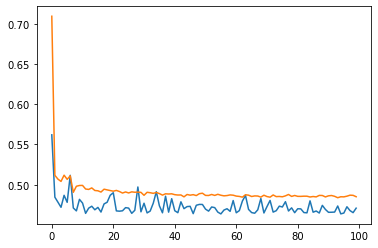

In [23]:
history_dict = history.history

#['val_mse]
#['mse']


y_1 = history_dict['val_mse']
y_2 = history_dict['mse']


plt.plot(y_1)
plt.plot(y_2)
plt.show()


---

### Interpreting Loss Visualizations

We have now created a visualization that should look something like this:

![alt text](https://i.imgur.com/0YDzVhq.png)

But how do we interpret this visualization?

The blue line is the mean squared error for the training data. You can see it plummeting fast as the model quickly learns.

The orange line is the validation data. This is a holdout set of data that the model checks after each epoch. You can see it dropping pretty quickly, too, but then it seems to stabilize somewhat by 20 epochs.

Toward the right side of the graph, you can see that our validation set says volatile but relatively flat, while our training data set keeps getting better and better.

Should we train more or less?

The constantly reducing blue line is actually a signal of overfitting on the training data.

The flat(ish) orange line signals this model is as good as we can get.

For this model we could possibly stop training after even 25 epochs and get similar performance.

But how do you know when to stop?

Luckily there is an *early stopping* algorithm that allows a model to stop training when validation data isn't improving.

In the example below, we set up a model to train for 1000 epochs; however, we add an early stopping callback. Early stopping stops training when the model isn't progressing upon validation.

If you run the code block below, you'll see far fewer than 1000 epochs run.

In [172]:
model = keras.Sequential([
  layers.Dense(64, input_shape=[feature_count]),
  layers.Dense(64),
  layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  training_df[feature_columns],
  training_df[target_column],
  epochs=EPOCHS,
  validation_split=0.2,
  callbacks=[early_stop],
)

Train on 13209 samples, validate on 3303 samples
Epoch 1/1000
13209/13209 [==============================] - 1s 88us/sample - loss: 0.6024 - mae: 0.5471 - mse: 0.6024 - val_loss: 0.5527 - val_mae: 0.5278 - val_mse: 0.5527
Epoch 2/1000
13209/13209 [==============================] - 1s 57us/sample - loss: 0.4962 - mae: 0.5127 - mse: 0.4962 - val_loss: 0.5246 - val_mae: 0.5167 - val_mse: 0.5246
Epoch 3/1000
13209/13209 [==============================] - 1s 62us/sample - loss: 0.4906 - mae: 0.5118 - mse: 0.4906 - val_loss: 0.5353 - val_mae: 0.5074 - val_mse: 0.5353
Epoch 4/1000
13209/13209 [==============================] - 1s 58us/sample - loss: 0.4874 - mae: 0.5092 - mse: 0.4874 - val_loss: 0.5266 - val_mae: 0.5176 - val_mse: 0.5266
Epoch 5/1000
13209/13209 [==============================] - 1s 59us/sample - loss: 0.4828 - mae: 0.5053 - mse: 0.4828 - val_loss: 0.5374 - val_mae: 0.5182 - val_mse: 0.5374
Epoch 6/1000
13209/13209 [==============================] - 1s 59us/sample - loss: 0.4

## Conclusion

We have now learned how to build a deep neural network to solve a regression problem. We have visualized our loss in order to determine when we might stop training, and we have utilized early stopping to avoid wasting time training a model.

Welcome to deep neural networks. They are deceptively simple to build, but they are very complex to master. When you can build a model to fit a domain, you can create amazing predictions that rival human experts.